# Virus-Host Species Relation Extraction
## Notebook 3 - Generative Model Training
### UC Davis Epicenter for Disease Dynamics

In [69]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re
import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

# Connect to the database backend and initalize a Snorkel session
#from lib.init import *
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels

from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

VirusHost = candidate_subclass('VirusHost', ['virus', 'host'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part III: Fitting a Generative Model
Generative models estimate joint probability of x and y in order to generate new data.
<br>
<br>
In our case, the Generative Model will unify weak sources (the individual LFs) by maximizing the marginal likelihood of the LFs to learn model parameters. We estimate the accuracy of each LF.
<br>
<br>
Intuitively, the labeling functions are modeled based on how much they agree or disagree with each other. Once the model is trained, the outputs of the LFs are combined into a single, noise-aware training label set (called 'train_marginals') for our end extractor (the discriminative model, an LSTM network). 

In [70]:
# First, load label matrices from notebook 2
from snorkel.annotations import LabelAnnotator

labeler = LabelAnnotator(lfs = [])
L_train = labeler.load_matrix(session, split=0)
L_dev = labeler.load_matrix(session, split=1)

#### Generative Model
According to data programming, the generative model is used as a more sophisticated way to unify lower quality labeling functions. Since our labeling functions will not be perfect classifiers (some may be low-quality) their accuracies are modeled. The end goal is to produce a single set of denoised training labels, which are then used to train an end extraction model (LSTM) in Notebook 4. 

**Parameter Definitions**
<br>
epochs:     A single pass through all the data in your training set
<br>
step_size:  The factor by which we update model weights after computing the gradient
<br>
decay:      The rate our update factor dimishes (decay) over time.
<br>
<br>
While training the model, we should include dependencies between LFs that may affect output. The DependencySelector function identifies a set of likely dependencies for us.

In [71]:
# Detect dependencies between LFs
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold = 0.1)
len(deps)

49

#### Testing different hyperparameters to find the best accuracy
We use a grid search to tune hyperparameters, optimizing the model

In [72]:
from snorkel.learning import GenerativeModel
from snorkel.learning import RandomSearch

param_ranges = {
    'step_size' : [1e-3, 1e-4, 1e-5, 1e-6, 0.1/L_train.shape[0]],
    'decay'     : [0.9, 0.95],
    'epochs'    : [50, 100],
    'reg_param' : [1e-3],
}

model_class_params = {'lf_propensity' : True}

searcher = RandomSearch(GenerativeModel, param_ranges, L_train, n=5, model_class_params=model_class_params)
%time gen_model, run_stats = searcher.fit(L_dev, L_gold_dev)
run_stats

[1] Testing step_size = 1.00e-05, decay = 9.00e-01, epochs = 50, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 0.2926829268292683
[GenerativeModel] Model saved as <GenerativeModel_0>.
[GenerativeModel] Model saved as <GenerativeModel_best>.
[2] Testing step_size = 6.09e-05, decay = 9.50e-01, epochs = 100, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 0.2926829268292683
[3] Testing step_size = 1.00e-05, decay = 9.50e-01, epochs = 50, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 0.2926829268292683
[4] Testing step_size = 1.00e-04, decay = 9.00e-01, epochs = 100, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 0.2926829268292683
[5] Testing step_size = 1.00e-06, decay = 9.50e-01, epochs = 100, reg_param = 1.00e-03
Inferred cardinality: 2
[GenerativeModel] F-1 Score: 0.2926829268292683
[GenerativeModel] Model <GenerativeModel_0> loaded.
Wall time: 29.3 s


,step_size,decay,epochs,reg_param,Prec.,Rec.,F-1
0,0.000010,0.90,50,0.001,1.0,0.171429,0.292683
1,0.000061,0.95,100,0.001,1.0,0.171429,0.292683
2,0.000010,0.95,50,0.001,1.0,0.171429,0.292683
3,0.000100,0.90,100,0.001,1.0,0.171429,0.292683
4,0.000001,0.95,100,0.001,1.0,0.171429,0.292683


The searcher selected the first model to be optimal. Let's rerun the model, this time with the optimal hyperparameters and including dependencies.

In [73]:
# Run the model, using deps to include the learned dependencies between LFs

# LF propensity set to True, which learns the likelihood of labeling an example
gen_model = GenerativeModel(lf_propensity = True)
gen_model.train(
    L_train, deps=deps, decay=0.90, epochs=50, step_size=1.00e-05, reg_param=1.00e-03
)

Inferred cardinality: 2


In [74]:
# The marginal predictions of the training labels
train_marginals = gen_model.marginals(L_train)

Let's visually explore the distribution of predicted training marginals. 
<br>
**Ideally, there should get a bimodal distribution with large separation between each peaks**

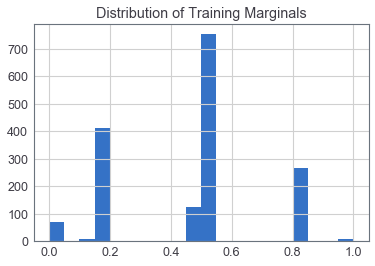

In [80]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20, range=(0.0, 1.0))
plt.title('Distribution of Training Marginals')
plt.show()

X axis is probability of classifying as positive or negative label (So a 0.5 would not be classified s anything). Based on shape above, we should add more labeling functions so there are more values on the ends which indicate good coverage on both the positive and negative side.

### Checking performance against development set labels

We will run the labeler on the development set, load in hand labels, then evaluate LF performance.

In [81]:
# gold (human-labeled) development set labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_dev

<102x1 sparse matrix of type '<class 'numpy.int32'>'
	with 89 stored elements in Compressed Sparse Row format>

#### Model Accuracies

In [82]:
L_dev.lf_stats(session, L_gold_dev)

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_detect,0,0.049020,0.049020,0.049020,3,2,0,0,0.600000
LF_infect,1,0.068627,0.009804,0.009804,7,0,0,0,1.000000
LF_misc,2,0.058824,0.019608,0.019608,5,1,0,0,0.833333
LF_isolate,3,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_v_cause_h,4,0.019608,0.000000,0.000000,2,0,0,0,1.000000
LF_v_h,5,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_uncertain,6,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_far_v_h,7,0.117647,0.009804,0.009804,0,0,7,2,0.222222
LF_far_h_v,8,0.176471,0.058824,0.029412,0,0,9,8,0.470588
LF_neg_h,9,0.000000,0.000000,0.000000,0,0,0,0,NaN


In [83]:
# Generative Model Metrics
dev_marginals = gen_model.marginals(L_dev)
_ = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.171
Neg. class accuracy: 1.0
Precision            1.0
Recall               0.171
F1                   0.293
----------------------------------------
TP: 12 | FP: 0 | TN: 32 | FN: 58



In [84]:
# Save training labels to use in end extraction model
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 1641 marginals
Wall time: 1.02 s
